# Neal's Funnel Target Practice

In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/Documents/PhD/MicroCanonicalHMC.jl/examples`
    Updating registry at `~/.julia/registries/General.toml`
    Updating `~/Documents/PhD/MicroCanonicalHMC.jl/examples/Project.toml`
  [0bf59076] + AdvancedHMC v0.6.1
  [f6369f11] + ForwardDiff v0.10.36
  [6fdf6af0] + LogDensityProblems v2.1.1
  [234d2aa0] + MicroCanonicalHMC v0.1.4
  [d330b81b] + PyPlot v2.11.2
  [295af30f] + Revise v3.5.14
  [fce5fe82] + Turing v0.32.0
    Updating `~/Documents/PhD/MicroCanonicalHMC.jl/examples/Manifest.toml`
  [47edcb42] + ADTypes v1.2.1
  [621f4979] + AbstractFFTs v1.5.0
  [80f14c24] + AbstractMCMC v5.2.0
  [7a57a42e] + AbstractPPL v0.8.4
  [1520ce14] + AbstractTrees v0.4.5
  [7d9f7c33] + Accessors v0.1.36
  [79e6a3ab] + Adapt v4.0.4
  [0bf59076] + AdvancedHMC v0.6.1
  [5b7e9947] + AdvancedMH v0.8.1
  [576499cb] + AdvancedPS v0.6.0
  [b5ca4192] + AdvancedVI v0.2.6
  [66dad0bd] + AliasTables v1.1.3
  [dce04be8] + ArgCheck v2.3.0
  [4fba245c] + ArrayInterface v7.10.0
  [a9b6321e

In [2]:
# The statistical inference frame-work we will use
using Turing
using LinearAlgebra
using Random
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

In [3]:
d = 21
@model function funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

@model function true_funnel()
    θ ~ Truncated(Normal(0, 3), -3, 3)
    z ~ MvNormal(zeros(d-1), I)
    zz = z .* exp(θ/2)
    x ~ MvNormal(zz, I)
    
end


true_funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Random.seed!(1)
(;x) = rand(true_funnel() | (θ=0,))
true_model = true_funnel() | (;x)

DynamicPPL.Model{typeof(true_funnel), (), (), (), Tuple{}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{x::Vector{Float64}}, DynamicPPL.DefaultContext}}(true_funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DynamicPPL.DefaultContext()))

## MCHMC

In [5]:
mchmc = MCHMC(20_000, 0.01; adaptive=true)
espl = externalsampler(mchmc)

Turing.Inference.ExternalSampler{MicroCanonicalHMC.MCHMCSampler, AutoForwardDiff{nothing, Nothing}, true}(MicroCanonicalHMC.MCHMCSampler(10000, 0.01, true, true, true, true, MicroCanonicalHMC.Hyperparameters{Float64}(0.0, 0.0, [0.0], 0.0, 0.0, 0.0), MicroCanonicalHMC.Leapfrog), AutoForwardDiff{nothing, Nothing}(nothing))

In [6]:
samples = sample(funnel_model, espl, 100_000);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/dMfiC/src/ProgressMeter.jl:594
Tuning: 100%|███████████████████████████████████████████| Time: 0:00:02
  ϵ:     2.01826321458691
  L:     1.483916404034785
  dE/d:  -0.030063611155834263
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


In [7]:
theta_mchmc = [samples.value.data[i, 1, :][1] for i in axes(samples.value.data)[1]]
x10_mchmc = [samples.value.data[i, 10+1, :][1] for i in axes(samples.value.data)[1]];

## NUTS

In [8]:
samples_hmc = sample(funnel_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:44


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 47.68 seconds
Compute duration  = 47.68 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ    0.0068    0.7046    0.0086    8518.4330    5607.3823    1.0001 ⋯
        z[1]    0.6168    0.7301    0.0033   48587.0673   34482.8338    1.0001 ⋯
        z[2]    0.6230    0.7366    0.0034   48124.4692   33961.6263    1.0000 ⋯
        z[3]   -0.4

In [9]:
theta_hmc = [samples_hmc.value.data[i, 1, :][1] for i in axes(samples_hmc.value.data)[1]]
x10_hmc = [samples_hmc.value.data[i, 10+1, :][1] for i in axes(samples_hmc.value.data)[1]];


In [10]:
truth_hmc = sample(true_model, NUTS(10, 0.95), 50_000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.8
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:22


Chains MCMC chain (50000×33×1 Array{Float64, 3}):

Iterations        = 11:1:50010
Number of chains  = 1
Samples per chain = 50000
Wall duration     = 24.25 seconds
Compute duration  = 24.25 seconds
parameters        = θ, z[1], z[2], z[3], z[4], z[5], z[6], z[7], z[8], z[9], z[10], z[11], z[12], z[13], z[14], z[15], z[16], z[17], z[18], z[19], z[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse     ess_bulk     ess_tail      rhat ⋯
      Symbol   Float64   Float64   Float64      Float64      Float64   Float64 ⋯

           θ    0.0021    0.7202    0.0055   18454.5803   22784.4035    1.0002 ⋯
        z[1]    0.5742    0.7101    0.0024   86154.7105   35473.5593    1.0001 ⋯
        z[2]    0.5853    0.7014    0.0024   86329.8835   36259.6981    1.0000 ⋯
        z[3]   -0.4

In [11]:
true_theta_hmc = [truth_hmc.value.data[i, 1, :][1] for i in axes(truth_hmc.value.data)[1]]
true_x10_hmc = [truth_hmc.value.data[i, 10+1, :][1] * exp(truth_hmc.value.data[i, 1, :][1]/2) for i in axes(truth_hmc.value.data)[1]];


## Comp

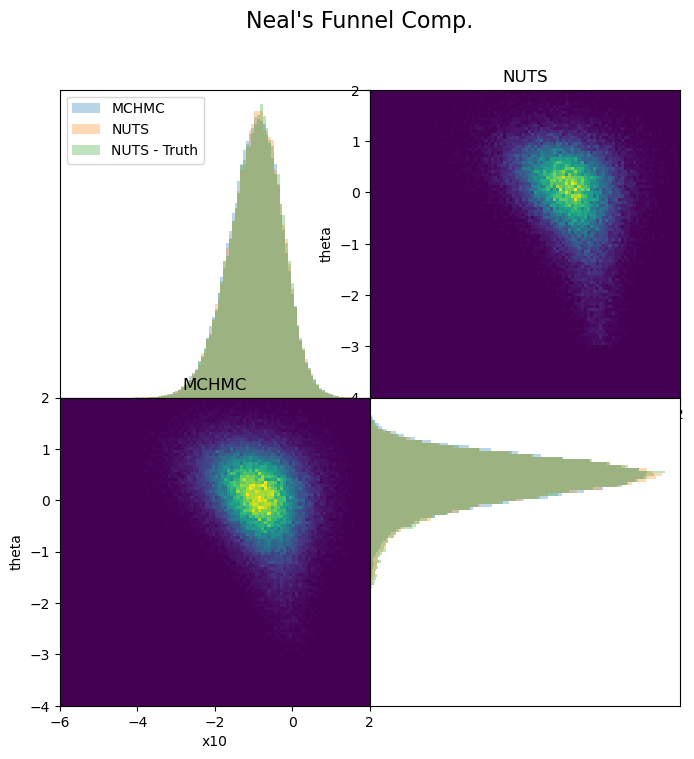

PyObject Text(0.5, 1.0, 'MCHMC')

In [12]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel Comp.", fontsize=16)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="MCHMC")
axis[1,1].hist(x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS")
axis[1,1].hist(true_x10_hmc, bins=100, density=true, range=[-6,2], alpha = 0.3, label="NUTS - Truth")
axis[1,1].legend()
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6, 2], alpha = 0.3)
axis[2,2].hist(true_theta_hmc, bins=100, density=true, orientation="horizontal", range=[-6,2], alpha = 0.3)
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[1,2].hist2d(true_x10_hmc, true_theta_hmc, bins=100, range=[[-6,2],[-4, 2]])
axis[1,2].set_xlabel("x10")
axis[1,2].set_ylabel("theta")
axis[1,2].set_title("NUTS")

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta")
axis[2,1].set_title("MCHMC")